 # Libraries Installation

In [ ]:
# Install the necessary libraries as mentioned in file requrirements.txt
!python3 -m pip install --upgrade pip
!pip install -r requirements.txt

# Genetic Algorithm

## Setting up Manual Functions

### Auxiliary Functions

In [ ]:
# --- SCHEDULE ADDITION ---

def add_schedule(schedule, wntk):
    for i in range(wntk.describe(level=1)['Links']['Pumps']):
        for j in range(int(wntk.options.time.duration / wntk.options.time.hydraulic_timestep) + 1):
            pump = wntk.get_link(wntk.pump_name_list[i])
            condition = wntr.network.controls.SimTimeCondition(wntk, '=', str(timedelta(hours=j)))
            action = wntr.network.controls.ControlAction(pump, 'status', schedule[i][j])
            control = wntr.network.controls.Control(condition, action, name=f'Control_pump{i}_time{j}')
            wntk.add_control(f"Control Pump ID : {i}, Hour : {j}", control)

In [ ]:
# --- ADDED SCHEDULE REMOVAL {EXCLUSIVELY THE ONES FROM ADD SCHEDULE}---

def remove_schedule(wntk):
    for i in range(wntk.describe(level=1)['Links']['Pumps']):
        for j in range(int(wntk.options.time.duration / wntk.options.time.hydraulic_timestep) + 1):
            wntk.remove_control(f"Control Pump ID : {i}, Hour : {j}")

In [ ]:
# --- RESHAPE INDIVIDUAL TO SCHEDULE ---

def reshape_individual(individual, wntk):

    # Reshape the individual to a 2D array
    schedule = np.array(individual).reshape(wntk.describe(level=1)['Links']['Pumps'], (int(wntk.options.time.duration / wntk.options.time.hydraulic_timestep) + 1)).tolist()

    return schedule

In [ ]:
# --- OBJECTIVE CALCULATION FUNCTION ---

def calculate_objective(individual, wntk):
    """
    Function to calculate the objective value for a given individual.
    """
    pass

### Objective Function Setup

In [ ]:
def evaluation():
    pass

## Setting up DEAP framework

### Setting up Libraries

In [ ]:
# Necessary Libraries for DEAP and Torch
from deap import base, tools, creator, algorithms

In [ ]:
import random

# --- CONFIGURATION ---
NUM_PUMPS = wn.describe(level=1)['Links']['Pumps']
NUM_TIMESTAMPS = (int(wn.options.time.duration / wn.options.time.hydraulic_timestep) + 1)
CHROM_SIZE = NUM_PUMPS * NUM_TIMESTAMPS  # No of Pumps * No of Timestamps

# --- CREATE TYPES ---

# Assigning Mult-Class Fitness Weigths
creator.create("FitnessMulti", base.Fitness, weights=(-1.0,-1.0,))

# Defining Individual
creator.create("Individual", list, fitness = creator.FitnessMulti)

toolbox = base.Toolbox()

# --- CREATE TOOLS ---

# Define Binary Genes
toolbox.register("attr_bool", random.randint, 0, 1)

# Define Individual (List of Binary Values)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=CHROM_SIZE)

# Define Random Population
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Register the Fitness function
toolbox.register("evaluate", evaluation)

# Define Selection Methodology
toolbox.register("select", tools.selNSGA3)

# Define Crossover Methodology
toolbox.register("mate", tools.cxTwoPoints)

# Define Mutation Methodology
toolbox.register("mutate", tools.mutFlipBit, indpb = 0.1)

# Set Hall of Fame
hof = tools.HallOfFame(10)

In [ ]:
# --- GENETIC ALGO LOOP---

def run_ga(pop_size = 40, generations = 5, cx_prob = 0.7, mut_prob = 0.4):
    
    population = toolbox.population(n = pop_size)

    # Multi-Objective Statistics
    stats = tools.Statistics(lambda ind: ind.fitness.values)

    # Run the Genetic Algorithm
    population, logbook = algorithms.eaMuPlusLambda(population=population,
                                                    toolbox=toolbox,
                                                    mu = round(pop_size * 0.7)
                                                    lambda_= round(pop_size * 0.5),
                                                    cxpb=cx_prob,
                                                    mutpb=mut_prob,
                                                    ngen=generations,
                                                    stats=stats,
                                                    halloffame=hof,
                                                    verbose=True,
                                                    )
    
    best_inds = hof
    print("Best Individual : ", best_inds)
    print("Fitness : ", best_inds.fitness.values)

    return best_inds, logbook, population, hof

best_sols, logbook, population, hof = run_ga()

# Network Simulation testing

In [ ]:
import wntr
import numpy as np
from datetime import timedelta
import pandas as pd

wn = wntr.network.WaterNetworkModel('Network Files/Net3.inp')

In [21]:
# Run a pressure dependent hydraulic simulation
wn.options.hydraulic.demand_model = 'PDD'
wn.options.hydraulic.required_pressure = 150 # m, The required pressure is set to create a scenario where not all demands are met

In [22]:
simulation = wntr.sim.WNTRSimulator(wn)
results = simulation.run_sim()

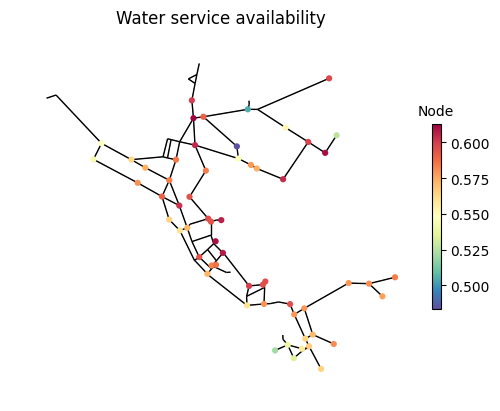

In [23]:
# Compute water service availability, defined as the ratio of delivered demand to the expected demand. 
expected_demand = wntr.metrics.expected_demand(wn)
demand = results.node['demand'].loc[:,wn.junction_name_list]
wsa = wntr.metrics.water_service_availability(expected_demand.sum(axis=0), demand.sum(axis=0))
ax = wntr.graphics.plot_network(wn, node_attribute=wsa, title='Water service availability')

wn.reset_initial_values()

In [24]:
cleaned = wsa.dropna()

In [25]:
cleaned

15     0.526620
35     0.582254
101    0.547259
103    0.543485
105    0.562867
107    0.573933
109    0.579873
111    0.590292
113    0.602393
115    0.583641
117    0.585122
119    0.604781
121    0.613057
123    0.600314
125    0.590519
127    0.504808
131    0.597217
139    0.551584
141    0.598458
143    0.610304
145    0.603932
147    0.574006
149    0.578561
151    0.548358
153    0.483846
157    0.584215
159    0.594296
161    0.596247
163    0.594220
166    0.606090
167    0.609819
171    0.607292
177    0.586426
185    0.572254
189    0.594372
191    0.559487
193    0.572104
197    0.564345
199    0.599899
201    0.595772
203    0.595649
205    0.559320
207    0.579695
209    0.595260
211    0.579081
213    0.579001
215    0.578900
217    0.580646
219    0.584138
225    0.577123
229    0.571437
231    0.581159
237    0.564935
239    0.566187
243    0.564378
247    0.556933
251    0.534292
253    0.521633
255    0.538982
dtype: float64

In [27]:
demand

,10,15,20,35,40,50,60,601,61,101,...,257,259,261,263,265,267,269,271,273,275
0,0.0,0.019459,0.0,0.055809,0.0,0.0,0.0,0.0,0.0,0.007786,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3600,0.0,0.019742,0.0,0.059584,0.0,0.0,0.0,0.0,0.0,0.012652,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7200,0.0,0.019512,0.0,0.059061,0.0,0.0,0.0,0.0,0.0,0.009408,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10800,0.0,0.019588,0.0,0.059312,0.0,0.0,0.0,0.0,0.0,0.009308,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14400,0.0,0.019761,0.0,0.062391,0.0,0.0,0.0,0.0,0.0,0.004995,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18000,0.0,0.012298,0.0,0.065384,0.0,0.0,0.0,0.0,0.0,0.006204,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21600,0.0,0.012519,0.0,0.064842,0.0,0.0,0.0,0.0,0.0,0.005809,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25200,0.0,0.000000,0.0,0.072167,0.0,0.0,0.0,0.0,0.0,0.007659,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28800,0.0,0.000000,0.0,0.071338,0.0,0.0,0.0,0.0,0.0,0.006897,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32400,0.0,0.000000,0.0,0.070129,0.0,0.0,0.0,0.0,0.0,0.007746,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
expected_demand

,10,15,20,35,40,50,60,601,61,101,...,257,259,261,263,265,267,269,271,273,275
0.0,0.0,0.039116,0.0,0.103279,0.0,0.0,0.0,0.0,0.0,0.016059,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3600.0,0.0,0.039116,0.0,0.107632,0.0,0.0,0.0,0.0,0.0,0.023249,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7200.0,0.0,0.039116,0.0,0.108452,0.0,0.0,0.0,0.0,0.0,0.017497,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10800.0,0.0,0.039116,0.0,0.108452,0.0,0.0,0.0,0.0,0.0,0.017257,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14400.0,0.0,0.039116,0.0,0.112995,0.0,0.0,0.0,0.0,0.0,0.009108,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18000.0,0.0,0.022712,0.0,0.114761,0.0,0.0,0.0,0.0,0.0,0.011025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21600.0,0.0,0.022712,0.0,0.112111,0.0,0.0,0.0,0.0,0.0,0.010186,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25200.0,0.0,0.000000,0.0,0.116212,0.0,0.0,0.0,0.0,0.0,0.012823,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28800.0,0.0,0.000000,0.0,0.114509,0.0,0.0,0.0,0.0,0.0,0.011505,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32400.0,0.0,0.000000,0.0,0.115140,0.0,0.0,0.0,0.0,0.0,0.013182,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
